In [2]:
# load the model from the file "sbm3x3_pclam_roc_0.210_auc_0.860"
import torch
from torch_geometric.transforms import TwoHop

import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')

from datasets.import_dataset import import_dataset
from utils.plotting import *
from trainer import Trainer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)
cpu = torch.device("cpu")

%load_ext autoreload
%autoreload 2


Using device: cuda


/home/user/Documents/danny/AAAI_pieclam/experiments/../datasets/import_dataset.py:410: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/torch/csrc/utils/tensor_new.cpp:275.)
  edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)
/home/user/anaconda3/envs/piegam/lib/python3.11/site-packages/torch_geometric/edge_index.py:784: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(




/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:304:::  
 2024-09-16 16:16:35 starting optimization of iegam on reddit on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 30,
        "dim_attr": 64,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 2000,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 1999


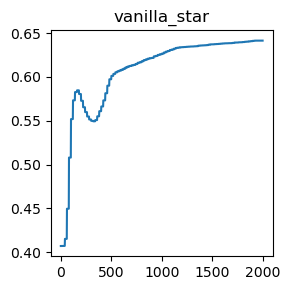



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:421:::  


FINISHED train 
 last accuracies:
vanilla_star: 0.6414225900486544


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:304:::  
 2024-09-16 16:19:38 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 30,
        "dim_attr": 64,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 2000,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:421:::  


FINISHED train 
 last accuracies:


UnboundLocalError: cannot access local variable 'accuracies_test' where it is not associated with a value

In [3]:

model_names = ['piegam']
ds_names = ['reddit','photo', 'elliptic']

for model_name in model_names:    
    for ds_name in ds_names:
        
        ds = import_dataset(ds_name)
        ds_to_use = ds
        if ds_name in ['reddit', 'photo', 'elliptic']:
            fat_ds = TwoHop()(ds)
            fat_ds.edge_attr = torch.ones(fat_ds.edge_index.shape[1]).bool()
            ds_to_use = fat_ds
    



        losseses = []
        acc_testses = []
        acc_valses = []
        
        '''change some of the configs manually e.g. 
        config_triplets = [['feat_opt', 'n_iter', 1000], ['prior_opt, 'lr', 0.0001], ...]'''
        config_triplets = []

        trainer_anomaly = Trainer(
            model_name=model_name,
            device=device,
            dataset=ds_to_use.clone(),
            attr_opt=True,
            task='anomaly',
            mighty_configs_dict=True,
            config_triplets_to_change=config_triplets
        )

        losses, acc_test, acc_val = trainer_anomaly.train(
            init_type='small_gaus',
            init_feats=True,
            acc_every=20,
            plot_every=-1,
            verbose=False,
            verbose_in_funcs=False
        )
        losseses.append(losses)
        acc_testses.append(acc_test)
        acc_valses.append(acc_val)
        
        if trainer_anomaly.clamiter.prior is not None:
            del trainer_anomaly.clamiter.prior.model
        del trainer_anomaly.data
        torch.cuda.empty_cache()

        del ds
        # del ds_to_use
        if ds_name in ['reddit', 'photo', 'elliptic']:
            del fat_ds
        torch.cuda.empty_cache()



# Ablation Study: Densification

In [13]:

# ABLATION STUDY WITHOUT DENSIFICATION

model_names = ['piegam']
ds_names = ['photo', 'elliptic', 'reddit']


final_accs = {'photo': {'vanilla_star':[],'prior':[],'prior_star':[]}, 'elliptic': {'vanilla_star':[],'prior':[],'prior_star':[]}, 'reddit': {'vanilla_star':[],'prior':[],'prior_star':[]}}

for model_name in model_names:    
    for ds_name in ds_names:
        
        ds = import_dataset(ds_name)
        for _ in range(10):   
            #! NOTICE: no densification!
            ds_to_use = ds

            
 
            # config_triplets = [['feat_opt', 'n_iter', 20],
            #                 ['prior_opt', 'n_iter', 20],]
            config_triplets = []

            trainer_anomaly = Trainer(
                model_name=model_name,
                device=device,
                dataset=ds_to_use.clone(),
                attr_opt=True,
                task='anomaly',
                mighty_configs_dict=True,
                config_triplets_to_change=config_triplets
            )

            losses, acc_test, acc_val = trainer_anomaly.train(
                init_type='small_gaus',
                init_feats=True,
                acc_every=20,
                plot_every=10000,
                verbose=False,
                verbose_in_funcs=False
            )

            final_accs[ds_name]['vanilla_star'].append(acc_test['vanilla_star'][-1])
            final_accs[ds_name]['prior'].append(acc_test['prior'][-1])
            final_accs[ds_name]['prior_star'].append(acc_test['prior_star'][-1])

        if trainer_anomaly.clamiter.prior is not None:
            del trainer_anomaly.clamiter.prior.model
        del trainer_anomaly.data
        torch.cuda.empty_cache()

        del ds
        del ds_to_use
       
        torch.cuda.empty_cache()





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:302:::  
 2024-09-14 23:05:49 starting optimization of piegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 30,
        "dim_attr": 100,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 3e-06,
        "n_iter": 500,
        "early_stop": 0
    },
    "prior_opt": {
        "n_iter": 1300,
        "lr": 2e-06,
        "noise_amp": 0.05,
        "weight_decay": 0.1,
        "early_stop": 0
    },
    "back_forth": {
        "n_back_forth": 3,
        "scheduler_step_size": 1,
        "scheduler_gamma": 0.5,
        "early_stop_fit": 0,
        "first_func_in_fit": "fit_feats"
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:546:::  
in fit,
first_func_in_fit='fit_feats'
second_function_name='fit_prior'


/home/user/Doc

In [15]:
# get mean and std for final accuracies.
for key in final_accs:
    print(key)
    for key2 in final_accs[key]:
        print(key2, np.mean(final_accs[key][key2]), np.std(final_accs[key][key2]))

photo
vanilla_star 0.5293380477898575 0.004605985829288573
prior 0.4324738066579411 0.008910819482738077
prior_star 0.4537777222730021 0.0030117688529705962
elliptic
vanilla_star 0.40093508042993575 0.0021141649818371337
prior 0.6378584290946936 0.02445695561468855
prior_star 0.6181259748707391 0.023257841239397
reddit
vanilla_star 0.5480807213588227 0.002172475245242343
prior 0.5088448429092982 0.03836777280380825
prior_star 0.5466093823500048 0.004664033321661206


# Vanilla methods

In [ ]:
# anomaly detection with iegam

model_names = ['iegam']
ds_names = ['photo', 'elliptic', 'reddit']

for model_name in model_names:    
    for ds_name in ds_names:
        
        ds = import_dataset(ds_name)
        if ds_name in ['reddit', 'photo', 'elliptic']:
            fat_ds = TwoHop()(ds)
            fat_ds.edge_attr = torch.ones(fat_ds.edge_index.shape[1]).bool()
            ds_to_use = fat_ds
        
        # ds_to_use = ds
        losseses = []
        acc_testses = []
        acc_valses = []
        
        '''change some of the configs manually e.g. 
        config_triplets = [['feat_opt', 'n_iter', 1000], ['prior_opt, 'lr', 0.0001], ...]'''
        config_triplets = []

        trainer_anomaly = Trainer(
            model_name=model_name,
            device=device,
            dataset=ds_to_use.clone(),
            attr_opt=True,
            task='anomaly',
            mighty_configs_dict=True,
            config_triplets_to_change=config_triplets
        )

        losses, acc_test, acc_val = trainer_anomaly.train(
            init_type='small_gaus',
            init_feats=True,
            acc_every=20,
            plot_every=-1,
            verbose=True,
            verbose_in_funcs=False
        )
        losseses.append(losses)
        acc_testses.append(acc_test)
        acc_valses.append(acc_val)
        
        if trainer_anomaly.clamiter.prior is not None:
            del trainer_anomaly.clamiter.prior.model
        del trainer_anomaly.data
        torch.cuda.empty_cache()

    del ds
    del ds_to_use
    if ds_name in ['reddit', 'photo', 'elliptic']:
        del fat_ds
    torch.cuda.empty_cache()